In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
from pathlib import Path
import sys

# Library imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Util imports
sys.path.append("../../")

### Relax borders of station influence and original gridded data

In [2]:
CITY_NAME = "Mandaue"  # add underscore here for Cagayan De Oro
RESOLUTION = 0.02
CELL_WIDTH = 3
STATION_RESOLUTION_DEGREES = 0.25
SMOOTHENING_WIDTH = 7
STATION_PURE_INFLUENCE_SCALE = 0.125
BIAS_CORRECTION_STD_LIMIT = 1.5

PROCESSED_PATH = Path("../../data/02-processed")
CORRECTED_PATH = PROCESSED_PATH / "bias-correction-radial-optimized"
CORRECTED_IMAGES_PATH = CORRECTED_PATH / "images"
CORRECTED_IMAGES_PATH.mkdir(parents=True, exist_ok=True)

STATION_NC = CORRECTED_PATH / f"station_{CITY_NAME.lower()}.nc"
GRIDDED_NC = (
    PROCESSED_PATH
    / f"input/chirts_chirps_regridded_interpolated_{CITY_NAME.split('_')[0].lower()}.nc"
)
CORRECTED_SUBSET_NC = CORRECTED_PATH / f"corrected_subset_{CITY_NAME.lower()}.nc"
CORRECTED_NC = CORRECTED_PATH / f"corrected_gridded_{CITY_NAME.lower()}.nc"

In [3]:
gridded_all_ds = xr.open_dataset(GRIDDED_NC).sel(band=1)[["tmin", "tmax", "precip"]]
corrected_subset_all_ds = xr.open_dataset(CORRECTED_SUBSET_NC)
station_ds = xr.open_dataset(STATION_NC)
station_lat = station_ds["lat"].values
station_lon = station_ds["lon"].values

# get common time axis
gridded_aligned_ds, _ = xr.align(
    gridded_all_ds,
    corrected_subset_all_ds,
    join="inner",
)

gridded_ds = gridded_all_ds.sel(time=gridded_aligned_ds["time"])
corrected_subset_ds = corrected_subset_all_ds.sel(time=gridded_aligned_ds["time"])

### Check if subset is within 2 std of surroundings for all

In [4]:
station_surroundings_buffer = STATION_RESOLUTION_DEGREES * 1.5

gridded_station_surroundings_ds = gridded_ds.where(
    (
        (gridded_ds.lat - station_lat) ** 2 + (gridded_ds.lon - station_lon) ** 2
        <= station_surroundings_buffer**2
    ),
    drop=False,
)

In [5]:
corrected_subset_time_mean_ds = corrected_subset_ds.mean(
    dim=["lat", "lon"], skipna=True
)
gridded_station_surroundings_time_mean_ds = gridded_station_surroundings_ds.mean(
    dim=["lat", "lon"], skipna=True
)
gridded_station_surroundings_time_std_ds = gridded_station_surroundings_ds.std(
    dim=["lat", "lon"], skipna=True
)

/home/jace/miniconda3/envs/climate-analytics/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jace/miniconda3/envs/climate-analytics/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [6]:
is_greater_than_negative_threshold = (
    -(corrected_subset_time_mean_ds - gridded_station_surroundings_time_mean_ds)
    > BIAS_CORRECTION_STD_LIMIT * gridded_station_surroundings_time_std_ds
)

is_within_threshold = (
    abs(corrected_subset_time_mean_ds - gridded_station_surroundings_time_mean_ds)
    <= BIAS_CORRECTION_STD_LIMIT * gridded_station_surroundings_time_std_ds
)

is_greater_than_positive_threshold = (
    corrected_subset_time_mean_ds - gridded_station_surroundings_time_mean_ds
) > BIAS_CORRECTION_STD_LIMIT * gridded_station_surroundings_time_std_ds

In [7]:
shifted_subset_ds = (
    (
        corrected_subset_ds
        + (
            (
                gridded_station_surroundings_time_mean_ds
                - BIAS_CORRECTION_STD_LIMIT * gridded_station_surroundings_time_std_ds
            )
            - corrected_subset_time_mean_ds
        )
    )
    * is_greater_than_negative_threshold
    + (corrected_subset_ds * is_within_threshold)
    + (
        corrected_subset_ds
        - (
            corrected_subset_time_mean_ds
            - (
                gridded_station_surroundings_time_mean_ds
                + BIAS_CORRECTION_STD_LIMIT * gridded_station_surroundings_time_std_ds
            )
        )
    )
    * is_greater_than_positive_threshold
)

### Prepare extended coordinates

In [8]:
lat_arr = corrected_subset_ds["lat"].to_numpy()
lat_min = lat_arr.min()
lat_max = lat_arr.max()
lat_min_add_arr = np.arange(
    lat_min - (CELL_WIDTH * RESOLUTION), lat_min - RESOLUTION, RESOLUTION
)
lat_max_add_arr = np.arange(
    lat_max + RESOLUTION, lat_max + ((CELL_WIDTH + 1) * RESOLUTION), RESOLUTION
)
lat_extended_arr = np.concatenate(
    (
        lat_min_add_arr,
        lat_arr,
        lat_max_add_arr,
    )
)

lon_arr = corrected_subset_ds["lon"].to_numpy()
lon_min = lon_arr.min()
lon_max = lon_arr.max()
lon_min_add_arr = np.arange(
    lon_min - (CELL_WIDTH * RESOLUTION), lon_min - RESOLUTION, RESOLUTION
)
lon_max_add_arr = np.arange(
    lon_max + RESOLUTION, lon_max + (CELL_WIDTH * RESOLUTION), RESOLUTION
)
lon_extended_arr = np.concatenate(
    (
        lon_min_add_arr,
        lon_arr,
        lon_max_add_arr,
    )
)

### Overlay corrected on top of original gridded

In [9]:
gridded_overlain_ds = gridded_ds.copy(deep=True)
gridded_overlain_ds.loc[
    dict(
        lat=corrected_subset_ds["lat"],
        lon=corrected_subset_ds["lon"],
    )
] = shifted_subset_ds.fillna(
    gridded_overlain_ds.loc[
        dict(
            lat=corrected_subset_ds["lat"],
            lon=corrected_subset_ds["lon"],
        )
    ]
)
# gridded_overlain_ds["tmin"][0].plot()
# plt.title(
#     f"{pd.DatetimeIndex(gridded_overlain_ds['time'])[0].strftime('%Y-%m-%d')}\nCorrected on top of CHIRTS Minimum Temperature"
# )
# plt.gca().set_aspect(1)
# plt.savefig(
#     CORRECTED_IMAGES_PATH
#     / f"{CITY_NAME.split('_')[0].lower()}_gridded_corrected_subset.png",
#     dpi=300,
#     transparent=True,
# )
# plt.show()

### Smoothen entire domain

In [10]:
gridded_smoothened_all_ds = gridded_overlain_ds.rolling(
    lat=SMOOTHENING_WIDTH, lon=SMOOTHENING_WIDTH, min_periods=1, center=True
).mean()

### Replace center of station influence with corrected

In [11]:
station_preserve_buffer = STATION_PURE_INFLUENCE_SCALE * STATION_RESOLUTION_DEGREES

corrected_subset_preserve_ds = shifted_subset_ds.where(
    (
        (shifted_subset_ds.lat - station_lat) ** 2
        + (shifted_subset_ds.lon - station_lon) ** 2
        <= station_preserve_buffer**2
    ),
    drop=False,
)

In [12]:
gridded_smoothened_all_ds.loc[
    dict(
        lat=corrected_subset_preserve_ds["lat"],
        lon=corrected_subset_preserve_ds["lon"],
    )
] = corrected_subset_preserve_ds.fillna(gridded_smoothened_all_ds)

In [13]:
# gridded_smoothened_all_ds.loc[
#     dict(
#         lat=corrected_subset_ds["lat"][2:-2],
#         lon=corrected_subset_ds["lon"][2:-2],
#     )
# ] = corrected_subset_ds.isel(
#     lat=range(len(corrected_subset_ds["lat"]))[2:-2],
#     lon=range(len(corrected_subset_ds["lon"]))[2:-2],
# )
# gridded_smoothened_all_ds = gridded_smoothened_all_ds.where(gridded_ds.notnull())

### Return the original gridded to the outer areas

In [14]:
corrected_preserve_buffer = 1.25 * STATION_RESOLUTION_DEGREES

gridded_smoothened_ds = gridded_ds.copy(deep=True)
gridded_smoothened_ds = gridded_smoothened_all_ds.where(
    (
        (gridded_smoothened_all_ds.lat - station_lat) ** 2
        + (gridded_smoothened_all_ds.lon - station_lon) ** 2
        <= corrected_preserve_buffer**2
    ),
    other=gridded_smoothened_ds,
    drop=False,
)
gridded_smoothened_ds

# get common time axis
gridded_smoothened_corrected_ds = gridded_smoothened_ds.where(gridded_ds.notnull())

In [15]:
# # gridded_smoothened_ds = gridded_ds.copy(deep=True)
# gridded_ds.loc[
#     dict(
#         lat=gridded_ds["lat"].sel(lat=lat_extended_arr, method="nearest"),
#         lon=gridded_ds["lon"].sel(lon=lon_extended_arr, method="nearest"),
#     )
# ] = gridded_smoothened_all_ds.sel(
#     lat=lat_extended_arr,
#     lon=lon_extended_arr,
#     method="nearest",
# )
# gridded_ds["tmin"][0].plot()
# plt.title(
#     f"{pd.DatetimeIndex(gridded_ds['time'])[0].strftime('%Y-%m-%d')}\nSmoothened Corrected Minimum Temperature"
# )
# plt.savefig(
#     CORRECTED_IMAGES_PATH / f"{CITY_NAME.split('_')[0].lower()}_gridded_smoothened.png",
#     dpi=300,
#     transparent=True,
# )
# plt.show()

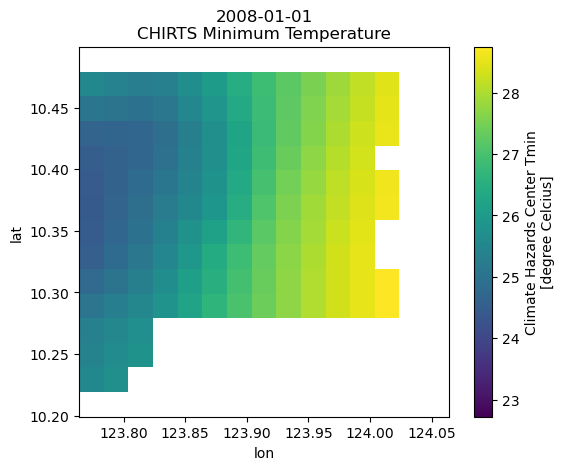

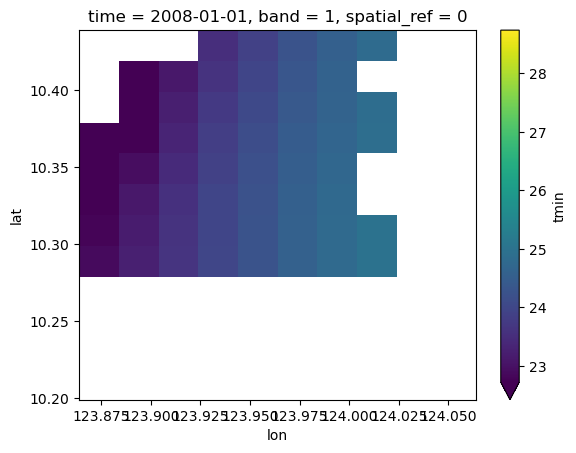

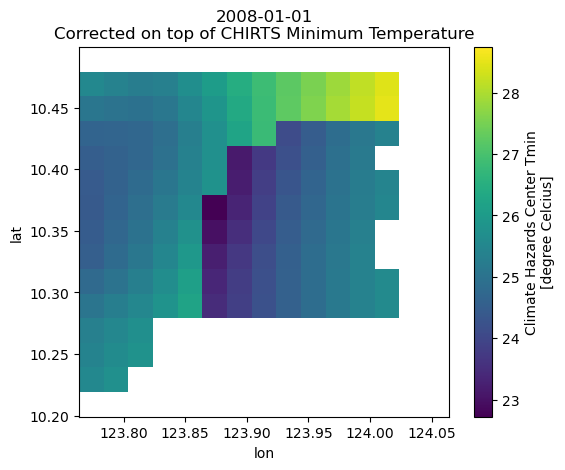

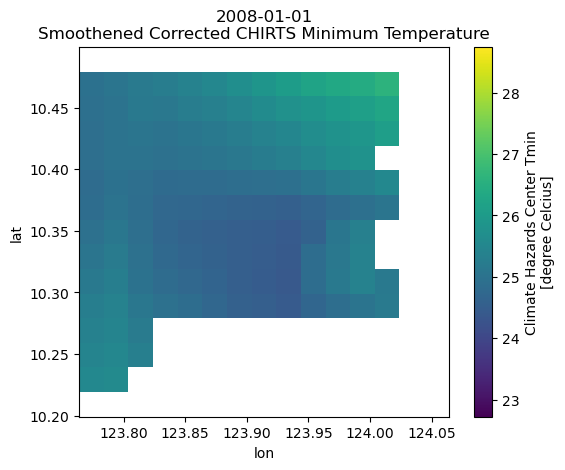

In [16]:
DATE = "2008-01-01"
var = "tmin"
cmap = "viridis"  # "RdBu_r"
dataset_dict = dict(
    tmin="CHIRTS Minimum Temperature",
    tmax="CHIRTS Maximum Temperature",
    precip="CHIRPS Precipitation",
)

plot_vmin = min(
    gridded_ds[var].sel(time=DATE, method="nearest").min(),
    gridded_overlain_ds[var].sel(time=DATE, method="nearest").min(),
    gridded_smoothened_corrected_ds[var].sel(time=DATE, method="nearest").min(),
)
plot_vmax = max(
    gridded_ds[var].sel(time=DATE, method="nearest").max(),
    gridded_overlain_ds[var].sel(time=DATE, method="nearest").max(),
    gridded_smoothened_corrected_ds[var].sel(time=DATE, method="nearest").max(),
)

gridded_ds[var].sel(time=DATE, method="nearest").plot(
    vmin=plot_vmin, vmax=plot_vmax, cmap=cmap
)
plt.title(f"{DATE}\n{dataset_dict[var]}")
plt.gca().set_aspect(1)
plt.savefig(
    CORRECTED_IMAGES_PATH / f"{CITY_NAME.split('_')[0].lower()}_gridded.png",
    dpi=300,
    transparent=True,
)
plt.show()

corrected_subset_ds[var].sel(time=DATE, method="nearest").plot(
    vmin=plot_vmin, vmax=plot_vmax, cmap=cmap
)
plt.show()

gridded_overlain_ds[var].sel(time=DATE, method="nearest").plot(
    vmin=plot_vmin, vmax=plot_vmax, cmap=cmap
)
plt.title(f"{DATE}\nCorrected on top of {dataset_dict[var]}")
plt.gca().set_aspect(1)
plt.savefig(
    CORRECTED_IMAGES_PATH
    / f"{CITY_NAME.split('_')[0].lower()}_gridded_corrected_subset.png",
    dpi=300,
    transparent=True,
)
plt.show()

gridded_smoothened_corrected_ds[var].sel(time=DATE, method="nearest").plot(
    vmin=plot_vmin, vmax=plot_vmax, cmap=cmap
)
plt.gca().set_aspect(1)

plt.title(f"{DATE}\nSmoothened Corrected {dataset_dict[var]}")
plt.savefig(
    CORRECTED_IMAGES_PATH / f"{CITY_NAME.split('_')[0].lower()}_gridded_smoothened.png",
    dpi=300,
    transparent=True,
)
plt.show()

In [17]:
gridded_smoothened_corrected_ds.to_netcdf(CORRECTED_NC, engine="scipy")